<a href="https://colab.research.google.com/github/Amaranta7/Practica1_COVID_mineria/blob/main/P1_COVID_mineria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**#Practicas Mineria_COVID-19

###Importacion de Datos 

**Datos Anuales del 21 Febrero del 2021 
al 21 Marzo 2021 (1mes)**

In [1]:
import requests
import io
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from typing import Tuple, List,Dict
from pandas import DataFrame


def get_soup(url: str) -> BeautifulSoup:
    response = requests.get(url)
    return BeautifulSoup(response.content, 'html.parser')

def print_tabulate(df: pd.DataFrame):
    print(tabulate(df, headers=df.columns, tablefmt='orgtbl'))

def get_csv_from_url(url: str) -> pd.DataFrame:
    s = requests.get(url).content
    return pd.read_csv(io.StringIO(s.decode('utf-8')))

def Covid() -> pd.DataFrame:
    soup = get_soup("https://es.wikipedia.org/wiki/Pandemia_de_COVID-19_en_México")
    list_of_lists = []
    rows = soup.find_all("table")[7].find_all('tr')
    for row in rows[1:]:
        columns = row.find_all('td')
        listado_de_valores_en_columnas = [column.text.strip() for column in columns]
        list_of_lists.append(listado_de_valores_en_columnas)
    return pd.DataFrame(list_of_lists, columns=["Estados","Casos","Cantidad de Fallecidos","porcentaje de Fallecidos","Cantidad de Recuperados","porcentaje de Recuperados","Casos por 100,000 habitantes","Reporte"])

df = Covid()

df.head()

,Estados,Casos,Cantidad de Fallecidos,porcentaje de Fallecidos,Cantidad de Recuperados,porcentaje de Recuperados,"Casos por 100,000 habitantes",Reporte
0,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None
2,Ciudad de México,592 456,38 132,6.44,531 532,89.72,6643.4,[133]​
3,Jalisco,229 072,11 120,4.85,210 879,92.06,2739.1,[134]​
4,Estado de México,228 018,30 527,13.39,185 357,81.29,1261.9,[135]​


In [2]:
df.to_csv("Estimadores_Covid.csv", index=False)

### Análisis de Datos

Import librerias que usaremos para graficas, analysis y tablas 

In [3]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import numbers
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import summary_table

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df_Modif = pd.read_csv("Estimadores_Covid.csv")
#Eliminamos las columnas mencionadas despues de .drop que sera el data fram de df_Modif
df_Modif = df_Modif.drop(['porcentaje de Fallecidos', 'porcentaje de Recuperados','Casos por 100,000 habitantes','Reporte'], axis=1)

In [5]:
df_Modif.head(5)

,Estados,Casos,Cantidad de Fallecidos,Cantidad de Recuperados
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,Ciudad de México,592 456,38 132,531 532
3,Jalisco,229 072,11 120,210 879
4,Estado de México,228 018,30 527,185 357


In [6]:
#Aqui agrupamos las columnas de cantidad de fallecidoa y la de cantidad de recuperados y la ponemos con la columna de casos
df_by_casos = df_Modif.groupby(["Cantidad de Fallecidos", "Cantidad de Recuperados"])[["Casos"]].aggregate(pd.DataFrame.sum)
df_by_casos.head(5)

,,Casos
Cantidad de Fallecidos,Cantidad de Recuperados,
1081,7415,8789
10 092,158 519,170 304
10 261,111 612,126 043
10 392,59 711,76 649
11 120,210 879,229 072


Aqui le asinamos ceros a los valores que tienen "null", es decir que son nulos 

In [7]:

#Aqui le asinamos ceros a los valores que tienen "null", con .fillna(0), es decir que son nulos 
df_Help = df_Modif[["Cantidad de Recuperados","Cantidad de Fallecidos","Casos"]].fillna(0)
df_Help.columns = ['Cantidad_de_Recuperados','Cantidad_de_Fallecidos','Casos']
df_Help.head(5)

,Cantidad_de_Recuperados,Cantidad_de_Fallecidos,Casos
0,0,0,0
1,0,0,0
2,531 532,38 132,592 456
3,210 879,11 120,229 072
4,185 357,30 527,228 018


Aqui observamos la informacion y tipos de datos que tiene el df_Help, observando que tiene datos que son tipo object, es decir que tienen texto , entonces tendremos que limiparlos para que sean de tipo texto 

In [8]:
df_Help.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Cantidad_de_Recuperados  36 non-null     object
 1   Cantidad_de_Fallecidos   36 non-null     object
 2   Casos                    36 non-null     object
dtypes: object(3)
memory usage: 992.0+ bytes


Aqui elimine las dos últimas filas y las dos últimas columnas del Data Frame pues son 0. Pero no modifico el DF original, lo asigno a uno nuevo.

In [9]:
df_Help_2 = df_Help.drop([0,1,34,35], axis = 0).reset_index().drop(['index'],axis = 1)

In [10]:
df_Help_2

,Cantidad_de_Recuperados,Cantidad_de_Fallecidos,Casos
0,531 532,38 132,592 456
1,210 879,11 120,229 072
2,185 357,30 527,228 018
3,158 519,10 092,170 304
4,111 612,10 261,126 043
5,59 711,10 392,76 649
6,61 824,6223,69 288
7,59 024,5837,65 991
8,54 921,5631,62 529
9,52 721,3985,62 082


Aqui modifique me fije que las columnas de casos, cantidad_de_fallecidos,cantidad_de_recuperados son de tipo object por que tienen "\xa" entre los numeros y eso hay que eliminarlo. para que quede solo dato numerico.

In [11]:
#Aqui modifique la primer columna de"Cantidad_de_Recuperados" para que quedaran puros datos numericos enteros.
df_Help_2["Cantidad_de_Recuperados"] = df_Help_2["Cantidad_de_Recuperados"].apply(lambda x: x.replace(u'\xa0', u''))
df_Help_2["Cantidad_de_Recuperados"]= df_Help_2["Cantidad_de_Recuperados"].astype(int)
df_Help_2["Cantidad_de_Recuperados"]

0     531532
1     210879
2     185357
3     158519
4     111612
5      59711
6      61824
7      59024
8      54921
9      52721
10     55173
11     49559
12     48606
13     46438
14     45402
15     36400
16     39185
17     30246
18     26758
19     29356
20     29772
21     26777
22     23514
23     24711
24     25102
25     20702
26     17273
27     11680
28      8896
29      8243
30      8512
31      7415
Name: Cantidad_de_Recuperados, dtype: int64

In [12]:
#Aqui modifique la segunda columna de"Cantidad_de_Fallecidos" para que quedaran puros datos numericos enteros.
df_Help_2["Cantidad_de_Fallecidos"] = df_Help_2["Cantidad_de_Fallecidos"].apply(lambda x: x.replace(u'\xa0', u''))
df_Help_2["Cantidad_de_Fallecidos"]= df_Help_2["Cantidad_de_Fallecidos"].astype(int)
df_Help_2["Cantidad_de_Fallecidos"]

0     38132
1     11120
2     30527
3     10092
4     10261
5     10392
6      6223
7      5837
8      5631
9      3985
10     3879
11     5036
12     5536
13     8584
14     4589
15     7687
16     3101
17     3895
18     5725
19     5555
20     3667
21     2618
22     2633
23     2782
24     1343
25     2327
26     2455
27     2242
28     1769
29     1206
30     1468
31     1081
Name: Cantidad_de_Fallecidos, dtype: int64

In [13]:
#Aqui modifique la Tercer columna de"Casos" para que quedaran puros datos numericos enteros.
df_Help_2["Casos"] = df_Help_2["Casos"].apply(lambda x: x.replace(u'\xa0', u''))
df_Help_2["Casos"] = df_Help_2["Casos"].astype(int)
df_Help_2["Casos"]

0     592456
1     229072
2     228018
3     170304
4     126043
5      76649
6      69288
7      65991
8      62529
9      62082
10     59752
11     59558
12     57139
13     56806
14     54426
15     45952
16     42807
17     36885
18     35944
19     35404
20     34269
21     31813
22     29021
23     28394
24     27465
25     24098
26     20810
27     18010
28     11168
29     10687
30     10285
31      8789
Name: Casos, dtype: int64

Aqui se hara la tabla de los casos que hay por estado

In [14]:
df_by_casosporEdo = df_Modif.groupby(["Estados"])[['Casos']].aggregate(pd.DataFrame.sum)
df_by_casosporEdo.head(5)

,Casos
Estados,
Aguascalientes,24 098
Baja California,45 952
Baja California Sur,27 465
Campeche,8789
Chiapas,10 285


In [15]:
#Aqui tabulamos los datos dela nueva base de datos llamada df_Help_2
print_tabulate(df_Help_2.head(5))

|    |   Cantidad_de_Recuperados |   Cantidad_de_Fallecidos |   Casos |
|----+---------------------------+--------------------------+---------|
|  0 |                    531532 |                    38132 |  592456 |
|  1 |                    210879 |                    11120 |  229072 |
|  2 |                    185357 |                    30527 |  228018 |
|  3 |                    158519 |                    10092 |  170304 |
|  4 |                    111612 |                    10261 |  126043 |


Grafico de Caja de Bigotes 

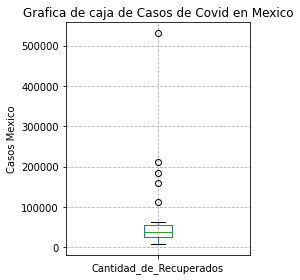

In [16]:
df_Help_2.loc[:,'Cantidad_de_Recuperados'].plot(kind='box',figsize=(4,4))
plt.title('Grafica de caja de Casos de Covid en Mexico') #Aqui es para agregar el titulo
plt.ylabel('Casos Mexico')
plt.grid(linestyle='--')
plt.tight_layout()

Aqui obtengo la info del segundo df_Help_2 los tipos de datos del df 

In [17]:
df_Help_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Cantidad_de_Recuperados  32 non-null     int64
 1   Cantidad_de_Fallecidos   32 non-null     int64
 2   Casos                    32 non-null     int64
dtypes: int64(3)
memory usage: 896.0 bytes


Aqui hacemos el plot de las columnas de "Cantidad_de_Recuperados" con  "Casos"

Text(0.5, 1.0, 'Plot de Cant Recuperados')

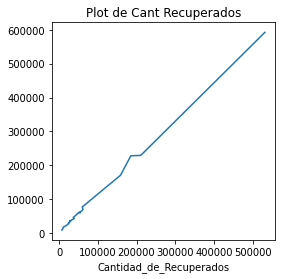

In [18]:
df_Help_2.plot(x="Cantidad_de_Recuperados", y = 'Casos', legend=False, figsize=(4,4))
plt.title("Plot de Cant Recuperados")  #Aqui es para agregar titulo al grafico 

Aqui hacemos el plot de las columnas de "Cantidad_de_Fallecidos" con "Casos"

Text(0.5, 1.0, 'Plot de Cant fallecidos')

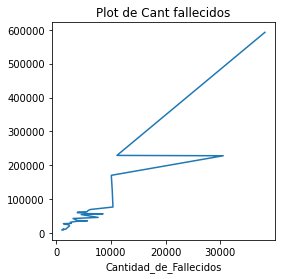

In [19]:
df_Help_2.plot(x="Cantidad_de_Fallecidos", y='Casos', legend=False, figsize=(4,4))
plt.title("Plot de Cant fallecidos")  #Aqui es para agregar titulo al grafico 

Hacemos dos graficos en una sola ventana 

Text(0.5, 1.0, 'Gráfico de Cant fallecidos')

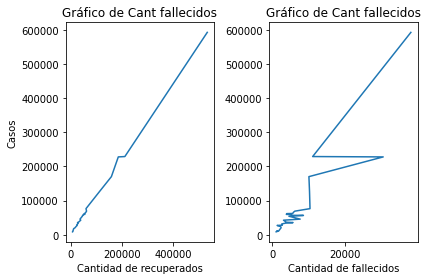

In [20]:
#Dos gráficos en una sola notación

plt.subplot(121) #GRAFICO 1
plt.plot(df_Help_2.loc[:,'Cantidad_de_Recuperados'],df_Help_2.loc[:,'Casos'])
plt.ylabel('Casos')
plt.xlabel('Cantidad de recuperados')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos") #Aqui es para agregar titulo al grafico 1
plt.subplot(122) #GRAFICO 2
plt.plot(df_Help_2.loc[:,'Cantidad_de_Fallecidos'],df_Help_2.loc[:,'Casos'])
plt.xlabel('Cantidad de fallecidos')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos")  #Aqui es para agregar titulo al grafico 2

Text(0.5, 1.0, 'Gráfico de Cant fallecidos')

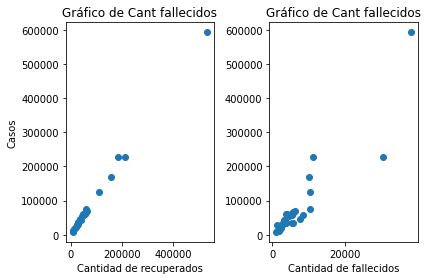

In [21]:
#DOS GRAFICOS DE PUNTOS en una sola notación

plt.subplot(121) #GRAFICO 1
plt.plot(df_Help_2.loc[:,'Cantidad_de_Recuperados'],df_Help_2.loc[:,'Casos'],'o')
plt.ylabel('Casos')
plt.xlabel('Cantidad de recuperados')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos") #Aqui es para agregar titulo al grafico 1
plt.subplot(122) #GRAFICO 2
plt.plot(df_Help_2.loc[:,'Cantidad_de_Fallecidos'],df_Help_2.loc[:,'Casos'],'o')
plt.xlabel('Cantidad de fallecidos')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos")  #Aqui es para agregar titulo al grafico 2

Text(0.5, 1.0, 'Gráfico de Cant fallecidos')

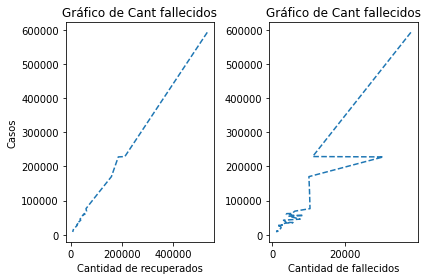

In [22]:
#DOS GRAFICOS PUNTEADOS en una sola notación.
plt.subplot(121) #GRAFICO 1
plt.plot(df_Help_2.loc[:,'Cantidad_de_Recuperados'],df_Help_2.loc[:,'Casos'],'--')
plt.ylabel('Casos')
plt.xlabel('Cantidad de recuperados')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos") #Aqui es para agregar titulo al grafico 1
plt.subplot(122) #GRAFICO 2
plt.plot(df_Help_2.loc[:,'Cantidad_de_Fallecidos'],df_Help_2.loc[:,'Casos'],'--')
plt.xlabel('Cantidad de fallecidos')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos")  #Aqui es para agregar titulo al grafico 2

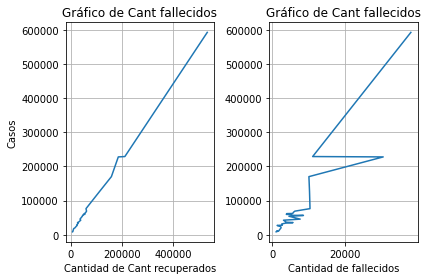

In [23]:
#DOS GRAFICOS CON LAMINA en una sola notación.
plt.subplot(121) #GRAFICO 1
plt.plot(df_Help_2.loc[:,'Cantidad_de_Recuperados'],df_Help_2.loc[:,'Casos'])
plt.ylabel('Casos')
plt.xlabel('Cantidad de Cant recuperados')
plt.title("Gráfico de Cant fallecidos") #Aqui es para agregar titulo al grafico 1
plt.grid()
plt.tight_layout()
plt.subplot(122) #GRAFICO 2
plt.plot(df_Help_2.loc[:,'Cantidad_de_Fallecidos'],df_Help_2.loc[:,'Casos'])
plt.xlabel('Cantidad de fallecidos')
plt.title("Gráfico de Cant fallecidos")  #Aqui es para agregar titulo al grafico 2
plt.grid()
plt.tight_layout()

Gráfico de casos confirmados con colores 

Text(0.5, 1.0, 'Plot Casos Confirmados COVID en México')

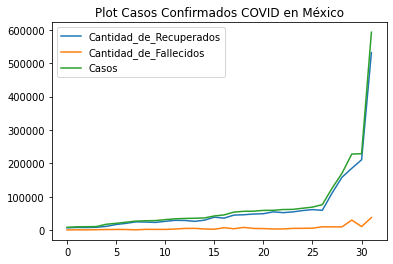

In [24]:
df_Help_2.sort_values('Casos').reset_index().drop('index',axis = 1).plot(kind = 'line')
plt.title("Plot Casos Confirmados COVID en México")  #Aqui es para agregar titulo al grafico 

Estadistica DESCRIPTIVA

In [25]:
#Estadistica DESCRIPTIVA de datos
df_Help_2.describe()

,Cantidad_de_Recuperados,Cantidad_de_Fallecidos,Casos
count,32.000000,32.000000,32.000000
mean,65806.875000,6605.562500,75684.812500
std,98209.325751,7876.687788,109341.711919
min,7415.000000,1081.000000,8789.000000
25%,24411.750000,2577.250000,28161.750000
50%,37792.500000,4287.000000,44379.500000
75%,56135.750000,6589.000000,63394.500000
max,531532.000000,38132.000000,592456.000000


Text(0.5, 1.0, 'Frecuencias de Casos confirmados COVID en México')

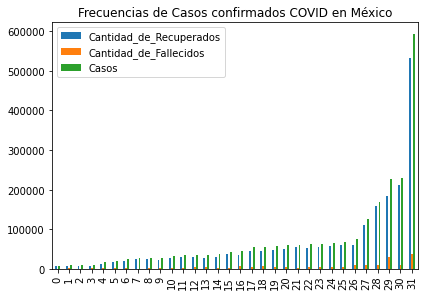

In [26]:
#Gráfica de barras de FRECUENCIAS de 3 columnas de casos
df_Help_2.sort_values('Casos').reset_index().drop('index',axis = 1).plot(kind = 'bar')
plt.tight_layout()
plt.title("Frecuencias de Casos confirmados COVID en México")  #Aqui es para agregar titulo al grafico 

Text(0.5, 1.0, 'Casos confirmados por Estado')

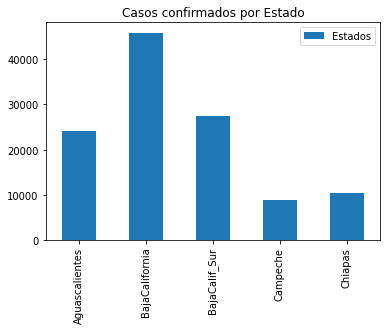

In [27]:
DJ = pd.DataFrame({'Estados':[24098,45952,27465,8789,10285]},index = ['Aguascalientes','BajaCalifornia','BajaCalif_Sur','Campeche','Chiapas'])
DJ.plot(kind='bar')
plt.title("Casos confirmados por Estado")  #Aqui es para agregar titulo al grafico 


Histograma de casos

In [28]:
import matplotlib.pyplot as plot

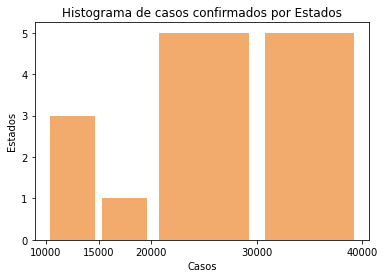

In [29]:

histograma=df_Help_2["Casos"]
intervalos = [10000,15000,20000,30000,40000] #indicamos los extremos de los intervalos
plot.hist(x=df_Help_2["Casos"], bins=intervalos, color='#F2AB6D', rwidth=0.85,)
plot.title('Histograma de casos confirmados por Estados')
plot.xlabel('Casos')
plot.ylabel('Estados')
plot.xticks(intervalos)

plot.show() #dibujamos el histograma

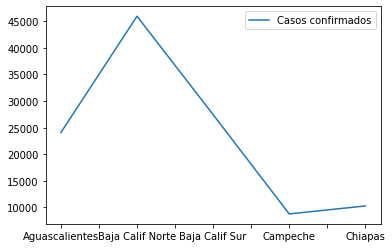

In [30]:
DJ2 = pd.DataFrame({'Casos confirmados':[24098,45952,27465,8789,10285]},index = ['Aguascalientes','Baja Calif Norte','Baja Calif Sur','Campeche','Chiapas'])
DJ2.plot(kind = 'line')

Aqui sacamos el p valor con Anova

In [31]:
#Sacamos el p-valor
modl = ols("Cantidad_de_Recuperados ~ Casos", data=df_Help_2).fit()
anova_df = sm.stats.anova_lm(modl, typ=2)
if anova_df["PR(>F)"][0] < 0.005:
    print("hay diferencias")
    print(anova_df)
    # Prueba tukey
    # imprimir los resultados
else:
    print("No hay diferencias")

hay diferencias
                sum_sq    df             F        PR(>F)
Casos     2.984498e+11   1.0  16356.884117  1.257497e-42
Residual  5.473839e+08  30.0           NaN           NaN


###REGRESION LINEAL *


*texto en cursiva*
Definición

La regresión lineal es, en palabras simples, cuando tenemos UNA sola variable que predice otra.

La variable que predice se denomina **independiente** y la variable predicha se denomina **dependiente**.

Modelo matemático.

$$y_i = \beta_0 + \beta_1x_i + \varepsilon_i$$

Donde:

1. $y_i$ es la variable de respuesta de la $i$-ésima prueba

2. $\beta_0$ y $\beta_1$ son parámetros.

3. $x_i$ es una constante conocida, el valor de la variable predictora en la $i$-ésima prueba.

4. $\varepsilon_i$ es un término de error aleatorio con $E\{\varepsilon_i \} = 0$ y $\sigma^2\{\varepsilon_i \} = \sigma^2$; $cov\left(\varepsilon_i , \varepsilon_j \right) = 0$.

Se define a las $\beta_0, \beta_1$ del modelo de regresión como **coeficientes de regresión**.

Se define como **pendiente de la línea de regresión** al coeficiente $\beta_1$, este indica el cambio de la media de la probabilidad de distribución de $y$ por incremento por unidad de $x$.

Se define como **intercepción de la línea de regresión** al coeficiente $\beta_0$.



In [32]:
HGU = {'x':df_Help_2["Cantidad_de_Recuperados"],'y':df_Help_2["Cantidad_de_Fallecidos"]}
HGUD = pd.DataFrame(HGU)

El "HGUD" trae las columnas de catidad de recuperados con cantidad de fallecidos.

1-Importamos la funcion linear_model y de ella LinearRegression

In [33]:
from sklearn.linear_model import LinearRegression

2-Construimos una linea de regresion

In [34]:
Linea_Regresion = LinearRegression()

3-Definimos ejes

In [35]:
Eje_X = HGUD[['x']] #ESTA ES LA NOTACION PARA LAS COLUMNAS
Eje_Y = HGUD[['y']]

4-Ajustamos el modelo a las variables dadas

In [36]:
Linea_Regresion.fit(Eje_X,Eje_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

El valor de la pendiente (β1) es;

In [37]:
#El valor de la pendiente (β1) es; 
Linea_Regresion.coef_

array([[0.07243349]])

El valor de la interseccion (β0) es; 

In [38]:
#El valor de la interseccion (β0) es; 
Linea_Regresion.intercept_

array([1838.94114393])

Podemos concluir que la línea de regresión ajustada a los datos es

$$\hat{y}_i = 1838.78274684 + 0.07243382 x_i$$

La ecuacion muestra que el coeficiente para los casos de fallecidos es de 0.07243382. El coeficiene indica que por cada caso de fallecido se puede esperar que los casos de covid-19 aumenten en promedio 7% en el siguiente mes.

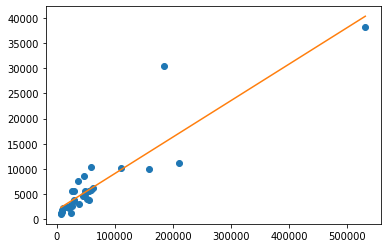

In [39]:
plt.plot(df_Help_2["Cantidad_de_Recuperados"],df_Help_2["Cantidad_de_Fallecidos"],'o')
plt.plot([min(df_Help_2["Cantidad_de_Recuperados"]),max(df_Help_2["Cantidad_de_Recuperados"])],[1838.78274684+0.07243382*min(df_Help_2["Cantidad_de_Recuperados"]),1838.78274684+0.07243382*max(df_Help_2["Cantidad_de_Recuperados"])])

**En el gráfico observamos que tenemos una regresion lineal positiva y que la dispersion de los datos tiene una  relacion mas fuerte.**

### Forecasting

Debido a que mi data fram analizado no me otorga las fechas, y se asume que los datos solo son de ciertos dias, no tiene una sucesion de serie, por que esta limitada, por lo que analizare con la prueba F muestra la variacion de media de los grupos, para asi analizar su pronostico de crecimiento o decrecimiento, que en este caso como no hacemos uso de fechas, solo observaremos que tanto se puede pronosticar los estados en su crecimiento o decrecimiento en casos confirmados de covid-19 , al igual que casos de recuperacion y casos de fallecidos. Aqui solo me centrare en la prueba F y en la cantidad de recuperados y en la cantidad de fallecidos.

In [40]:
from statsmodels.stats.anova import anova_lm

In [41]:
from statsmodels.formula.api import ols

In [42]:
HGU = {'x':df_Help_2["Cantidad_de_Recuperados"],'y':df_Help_2["Cantidad_de_Fallecidos"]}
HGUD.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
x,531532,210879,185357,158519,111612,59711,61824,59024,54921,52721,55173,49559,48606,46438,45402,36400,39185,30246,26758,29356,29772,26777,23514,24711,25102,20702,17273,11680,8896,8243,8512,7415
y,38132,11120,30527,10092,10261,10392,6223,5837,5631,3985,3879,5036,5536,8584,4589,7687,3101,3895,5725,5555,3667,2618,2633,2782,1343,2327,2455,2242,1769,1206,1468,1081


In [43]:
#Necesitamos ajustar el modelo mediante ols, el primer argumento es la ecuacion de la regresion lineal.
#El segundo es el data fram que estamos analizando.

HGUD_fit = ols(formula='y ~ x',data = HGUD).fit()

In [44]:
Anova_HGUD = anova_lm(HGUD_fit)
Anova_HGUD

,df,sum_sq,mean_sq,F,PR(>F)
x,1.0,1.568722e+09,1.568722e+09,132.722539,1.534959e-12
Residual,30.0,3.545867e+08,1.181956e+07,NaN,NaN


Aqui tenemos la prueba F con un valor de 132.72 y residual de 0.

In [45]:
#PARA COMPARAR LA F CALCULADA CON EL VALOR CRITICO TENEMOS QUE IMPORTAR LA SIGUIENTE FUNCION

from scipy.stats import f as Valor_Critico_F

In [46]:
#EXTRAEMOS EL VALOR F DE Anova_HGUD

Estadistico_Prueba_HGUD = Anova_HGUD.loc['x','F']

In [47]:
#CALCULAMOS EL VALOR CRITICO

Valor_Critico_HGUD = Valor_Critico_F.isf(0.05,1,len(HGUD.index)-2)

In [48]:
#NOS PREGUNTAMOS ENTONCES

Estadistico_Prueba_HGUD > Valor_Critico_HGUD

True

In [49]:
Linea_Regresion_HGUD = LinearRegression()
Linea_Regresion_HGUD.fit(HGUD[['x']],HGUD[['y']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
Linea_Regresion_HGUD.coef_

array([[0.07243349]])

In [51]:
Linea_Regresion_HGUD.intercept_

array([1838.94114393])

$$\hat{y} = 0.07243349\cdot x + 1838.94114393$$

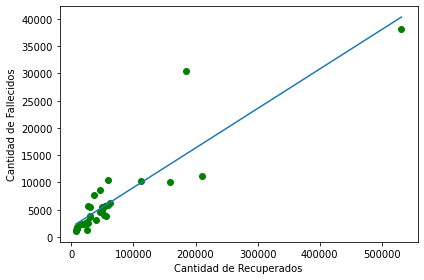

In [52]:
#GRAFIQUEMOS LOS DATOS Y LA LINEA DE REGRESION

plt.plot(df_Help_2["Cantidad_de_Recuperados"],df_Help_2["Cantidad_de_Fallecidos"],'o',color = 'green')
plt.plot([min(df_Help_2["Cantidad_de_Recuperados"]),max(df_Help_2["Cantidad_de_Recuperados"])],[0.07243349*min(df_Help_2["Cantidad_de_Recuperados"])+1838.94114393,0.07243349*max(df_Help_2["Cantidad_de_Recuperados"])+1838.94114393])
plt.ylabel('Cantidad de Fallecidos')
plt.xlabel('Cantidad de Recuperados')
plt.tight_layout()

In [53]:
print_tabulate(df.head(50))

|    | Estados                                                                                                       | Casos   | Cantidad de Fallecidos   |   porcentaje de Fallecidos | Cantidad de Recuperados   |   porcentaje de Recuperados |   Casos por 100,000 habitantes | Reporte   |
|----+---------------------------------------------------------------------------------------------------------------+---------+--------------------------+----------------------------+---------------------------+-----------------------------+--------------------------------+-----------|
|  0 |                                                                                                               |         |                          |                            |                           |                             |                                |           |
|  1 |                                                                                                               |         |        

**HASTA AQUI ES FORECASTING**

Aqui inicia Classsification

In [54]:
from pandas import DataFrame
HGU = {'x':df_Help_2["Cantidad_de_Recuperados"],'y':df_Help_2["Cantidad_de_Fallecidos"]}
HGU_df= DataFrame(HGU,columns=['x','y'])
print(HGU_df)

         x      y
0   531532  38132
1   210879  11120
2   185357  30527
3   158519  10092
4   111612  10261
5    59711  10392
6    61824   6223
7    59024   5837
8    54921   5631
9    52721   3985
10   55173   3879
11   49559   5036
12   48606   5536
13   46438   8584
14   45402   4589
15   36400   7687
16   39185   3101
17   30246   3895
18   26758   5725
19   29356   5555
20   29772   3667
21   26777   2618
22   23514   2633
23   24711   2782
24   25102   1343
25   20702   2327
26   17273   2455
27   11680   2242
28    8896   1769
29    8243   1206
30    8512   1468
31    7415   1081


<function matplotlib.pyplot.show>

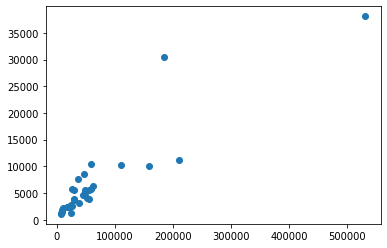

In [55]:
import matplotlib.pyplot as plt
plt.scatter(HGU_df['x'],HGU_df['y'])
plt.show

Gráfico de dispersion, observamos que los datos no estan tan dispersos, es decir que mantienen una correlacion todos centrados mas en un centro 

In [56]:
import sklearn

In [57]:
#1-Unicaremos los centroides, dependiendo los centroides que le indiquemos
from sklearn.cluster import KMeans
KMeans = KMeans(n_clusters=3).fit(HGU_df)
centroids = KMeans.cluster_centers_
print(centroids)

[[ 33626.7037037    4120.22222222]
 [531532.          38132.        ]
 [166591.75        15500.        ]]


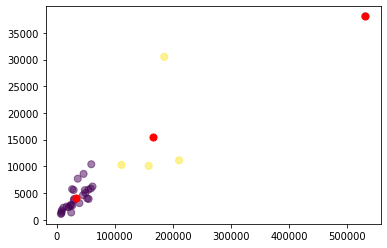

In [58]:
plt.scatter(HGU_df['x'],HGU_df['y'],c=KMeans.labels_.astype(float),s=50,alpha=0.5)
plt.scatter(centroids[:,0],centroids[:,1],c="red",s=50)
plt.show()

Los datos de casos confirmados recuperados y de fallecidos, que serian el total de casos, se centra mas entre los cienmiles de casos por dia.

### Forecasting PRUEBA otros

###Relación

Definición
Existen diversas maneras para medir hasta que punto las diferentes variables son interdependientes. Sí una variable esta relacionada con otra, es decir, por ejemplo,x esta relacionada con y, entonces podemos analizar que tanto están relacionadas.

En particular, existen tres maneras de analizar la relación entre variables.

Visual
Coeficiente de Pearson
p-valor
Analizar la relación entre variables de manera visual nos da una PISTA de la relación entre ellas, sin embargo, no es prueba contundente de esta.

El coeficiente de Pearson es un valor estadístico que nos indica que de que forma están relacionadas las variables. El coeficiente de Pearson tiene el siguiente criterio.

Valor del Coeficiente de Pearson	Significado
Cercano a 1	Tenemos una relación lineal positiva
Cercano a 0	No existe una relación lineal entre las variables
Cercano a -1	Tenemos una relación lineal negativa
Por su lado, el p-valor nos dice lo seguros que estamos de la relación calculada.

Valor del p-valor	Significado
0.01<p<0.05
Fuerte certeza de relación lineal
0.05<p<0.1
Moderada certeza de relación lineal
p<0.1	Débil certeza de relación lineal
p>0.1	No existe relación lineal

In [59]:
HGU = {'Cantidad_Recuperados(x)':df_Help_2["Cantidad_de_Recuperados"],'Cantidad_Fallecidos(y)':df_Help_2["Cantidad_de_Fallecidos"]}
HGUD = pd.DataFrame(HGU)
HGUD

,Cantidad_Recuperados(x),Cantidad_Fallecidos(y)
0,531532,38132
1,210879,11120
2,185357,30527
3,158519,10092
4,111612,10261
5,59711,10392
6,61824,6223
7,59024,5837
8,54921,5631
9,52721,3985


In [60]:
from sklearn.linear_model import LinearRegression

Linea_Regresion = LinearRegression()

Linea_Regresion.fit(HGUD[['Cantidad_Recuperados(x)']],HGUD[['Cantidad_Fallecidos(y)']])

print('La pendiente es : ',Linea_Regresion.coef_,'\nLa interseccion es : ',Linea_Regresion.intercept_)

La pendiente es :  [[0.07243349]] 
La interseccion es :  [1838.94114393]


$$\hat{y} = 1.28679867e-07\cdot x -4845.33664031$$

(0.0, 76386.29590895714)

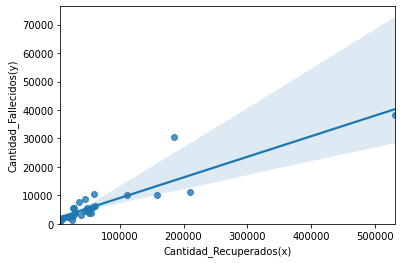

In [61]:
#ANALIZAMOS DE MANERA VISUAL

import seaborn as sns

sns.regplot( x = 'Cantidad_Recuperados(x)', y = 'Cantidad_Fallecidos(y)', data = HGUD,ci = 95)
plt.ylim(0,)

#### Coeficiente de Pearson y $p$-valor

Para observar el coeficiente de Pearson y el $p$-valor utilizamos la función stats de la librería scipy y dentro de ella pearsonr.

In [62]:
#1.Importamos la funcion 
from scipy import stats

#2.Mandamos a llamar la funcion pearsonr
Pearson = stats.pearsonr(HGUD.loc[:,'Cantidad_Recuperados(x)'], HGUD.loc[:,'Cantidad_Fallecidos(y)'])

In [63]:
#3.IMPRIMIMOS EL COEFICIENTE DE PEARSON Y EL P-VALOR
print('El coeficiente de Pearson es ',Pearson[0],'\nEl P-Valor es ',Pearson[1])

El coeficiente de Pearson es  0.9031262897264036 
El P-Valor es  1.5349591277583208e-12


In [64]:
#VERIFICAMOS lo QUE NOS DICE EL P-VALOR
if 0.01 < Pearson[1] and Pearson[1] < 0.05 :
  print('Fuerte certeza de relacion lineal')
elif 0.05 < Pearson[1] and Pearson[1] < 0.1 :
  print('Moderada certeza de relacion lineal')
elif Pearson[1] < 0.1:
  print('Debil certeza de relacion lineal')
elif Pearson[1] > 0.1:
  print('No existe certeza de relacion lineal')

Debil certeza de relacion lineal


#### $R^2$ Coeficiente de determinación

El coeficiente de determinación nos dice lo cerca que están los datos de la línea de regresión ajustada.

|Valor $R^2$|Significado|
|--|--|
|Valor cercano a 1|La línea de regresión es un buen ajuste a los datos|
|Valor cercano a 0|La línea de regresión no es un buen ajuste a los datos|

Sí el valor de $R^2$ es negativo puede deberse a un sobre ajuste de los datos.

Este coeficiente es aplicable a una regresión lineal, múltiple y polinómica, entre otras.

In [65]:
HGUD
#1: IMPORTAMOS

from sklearn.linear_model import LinearRegression

LM = LinearRegression()

#2: AJUSTAMOS

LM.fit(HGUD[['Cantidad_Recuperados(x)']], HGUD[['Cantidad_Fallecidos(y)']])

#3: CALCULAMOS EL COEFICIENTE DE DETERMINACION

print('El coeficiente de determinacion es ',LM.score(HGUD[['Cantidad_Recuperados(x)']], HGUD[['Cantidad_Fallecidos(y)']]))

El coeficiente de determinacion es  0.8156370951949801


El coeficiente de determinación es la proporción de la varianza total de la variable explicada por la regresión. Es también denominado R cuadrado y sirve para reflejar la bondad del ajuste de un modelo a la variable que se pretende explicar.

El coeficiente de determinación puede adquirir resultados que oscilan entre 0 y 1. Así, cuando adquiere resultados más cercanos a 1, mayor resultará el ajuste del modelo a la variable que se pretende aplicar para el caso en concreto. Por el contrario, cuando adquiere resultados que se acercan al valor 0, menor será el ajuste del modelo a la variable que se pretende aplicar y, justo por eso, resultará dicho modelo menos fiable.

**Entonces aqui el Coeficiente de determinacion se acerca mas al 1, por lo que mayor resultará el ajuste del modelo a la variable de los casos confirmados de COVID-19**

###Data classification

lINK DE EJEMPLO DE DATA CLASSIFICATION PARA VERLO

https://www.youtube.com/watch?v=mmB9RroFv8c

In [66]:
from pandas import DataFrame
HGU = {'x':df_Help_2["Cantidad_de_Recuperados"],'y':df_Help_2["Cantidad_de_Fallecidos"]}
HGU_df= DataFrame(HGU,columns=['x','y'])
print(HGU_df)

         x      y
0   531532  38132
1   210879  11120
2   185357  30527
3   158519  10092
4   111612  10261
5    59711  10392
6    61824   6223
7    59024   5837
8    54921   5631
9    52721   3985
10   55173   3879
11   49559   5036
12   48606   5536
13   46438   8584
14   45402   4589
15   36400   7687
16   39185   3101
17   30246   3895
18   26758   5725
19   29356   5555
20   29772   3667
21   26777   2618
22   23514   2633
23   24711   2782
24   25102   1343
25   20702   2327
26   17273   2455
27   11680   2242
28    8896   1769
29    8243   1206
30    8512   1468
31    7415   1081


<function matplotlib.pyplot.show>

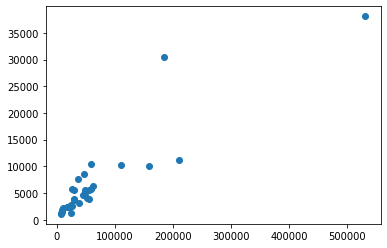

In [67]:
import matplotlib.pyplot as plt
plt.scatter(HGU_df['x'],HGU_df['y'])
plt.show

Gráfico de dispersion, observamos que los datos no estan tan dispersos, es decir que mantienen una correlacion todos centrados mas en un centro 

In [68]:
import sklearn

In [69]:
#1-Unicaremos los centroides, dependiendo los centroides que le indiquemos
from sklearn.cluster import KMeans
KMeans = KMeans(n_clusters=3).fit(HGU_df)
centroids = KMeans.cluster_centers_
print(centroids)

[[166591.75        15500.        ]
 [ 33626.7037037    4120.22222222]
 [531532.          38132.        ]]


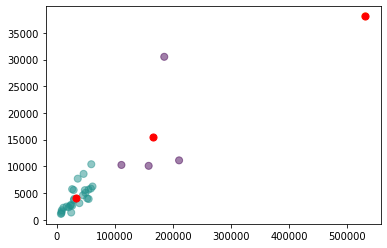

In [70]:
plt.scatter(HGU_df['x'],HGU_df['y'],c=KMeans.labels_.astype(float),s=50,alpha=0.5)
plt.scatter(centroids[:,0],centroids[:,1],c="red",s=50)
plt.show()

Los datos de casos confirmados recuperados y de fallecidos, que serian el total de casos, se centra mas entre los cienmiles de casos por dia.

###Data clustering

Es util por que se tienen menos de 10000 individuos*

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

NORMALIZAMOS los datos:para que el agrupamiento no se valla parcializado a una sola variable.

In [ ]:
from sklearn.preprocessing import normalize
data_HGU=normalize(HGU_df)

Aqui normalizamos los datos

In [ ]:
data_HGU= DataFrame(data_HGU,columns=['x','y'])
print(HGU_df)

link para guiarme en base a este ejemplo 
https://www.youtube.com/watch?v=kIanGE8a98s

In [ ]:
data_HGU=pd.DataFrame(data_HGU,columns=data_HGU.columns)
data_HGU.head()